In [1]:
from util import go_to_project_root
go_to_project_root()

CWD cambiado a la raíz del proyecto: /home/epsilon/Documents/doctorado/S2/ENSTA630/tareas/HW2


# Problema 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from source.fit.inference.test_chow import test_chow

from source.data.loaders import create_dataset
from source.models.var import VAR
from source.data.transform import create_var_dataset
from source.display.hw import hw2 as plots
from source.display.hw.hw1 import save_figure
from source.fit.bootstrap import run_bootstrap_mp

%load_ext autoreload
%autoreload 2

### Cargar datos

In [3]:
path = './data/base_25.xls'
dataset = create_dataset(path, problem=5)

[INFO] ¡Datos cargados exitosamente!


In [4]:
i_reshaped = dataset['i'][12:]
X = np.vstack([dataset['pi'], dataset['y'], i_reshaped]).T
X = np.vstack([dataset['pi'], dataset['y'], i_reshaped]).T


In [5]:
dataset['t'][12:].shape, X.shape

((185,), (185, 3))

✅ Figura guardada exitosamente en ./presentation/figures/hw2/data.pdf


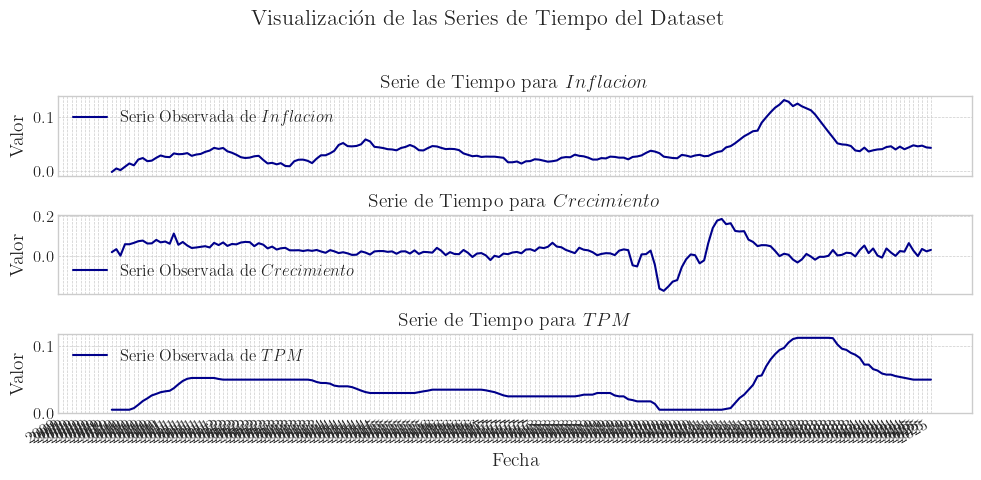

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(10, 5), sharex=False)
plots.plot_time_series(X, 
                       dates=dataset['t'][12:],
                       variable_names=['Inflacion', 
                                       'Crecimiento',
                                       'TPM'],
                        fig=fig, axes=axes)
axes[0].set_xticks(dataset['t'])
save_figure(fig, './presentation/figures/hw2/data.pdf')

### Seleccionando el mejor modelo

In [20]:
from source.fit.model_selection import hannan_rissanen

In [48]:
metrics = hannan_rissanen(X, 
                        max_rezagos=30,
                        verbose=False)

Evaluando órdenes de rezago del 1 al 30...
Evaluación completada.


✅ Figura guardada exitosamente en ./presentation/figures/hw2/p2/model_selection.pdf


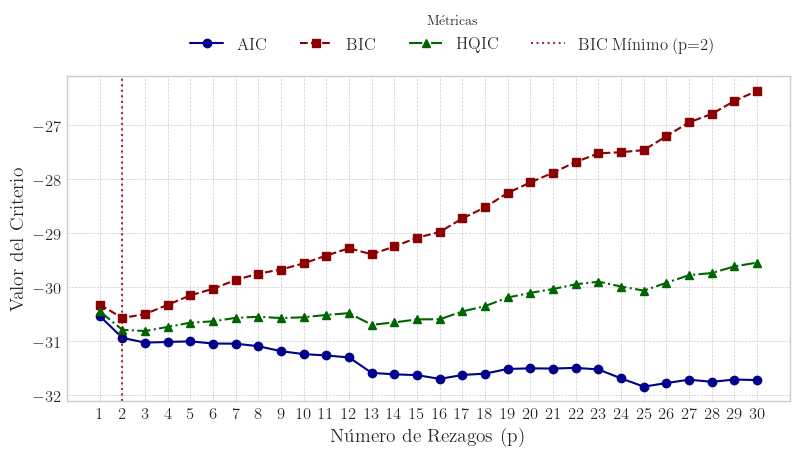

In [58]:
fig, ax = plt.subplots(figsize=(9, 4))
fig, ax  = plots.graficar_criterios_var(metrics, fig=fig, ax=ax)
save_figure(fig, './presentation/figures/hw2/p2/model_selection.pdf')

### Modelo

In [45]:
p = 2          # rezagos
n = X.shape[1] # numero de variables
model = VAR(inp_dim=n, 
            c=0,
            p=p)
_ = model.fit(X)
model._is_stationary()

np.True_

In [46]:
# 2. Define la función que extrae la estadística
get_irf_fn = lambda m: m.get_irf(H=24, method='cholesky')

# 3. Ejecuta el bootstrap PARALELIZADO
irf_point, irf_lower, irf_upper = run_bootstrap_mp(
    fitted_var=model,
    statistic_fn=get_irf_fn,
    n_replications=10000, # Ahora puedes subir el número de réplicas!
    confidence_level=0.95,
    n_jobs=-1 # Usa todos los cores disponibles
)


Iniciando simulación paralela con 10000 iteraciones en 8 procesos...


Bootstrap en Paralelo: 100%|██████████| 10000/10000 [00:14<00:00, 671.76it/s]



Cálculo finalizado. 10000/10000 réplicas exitosas.


✅ Figura guardada exitosamente en ./presentation/figures/hw2/p2/irf_cholesky.pdf


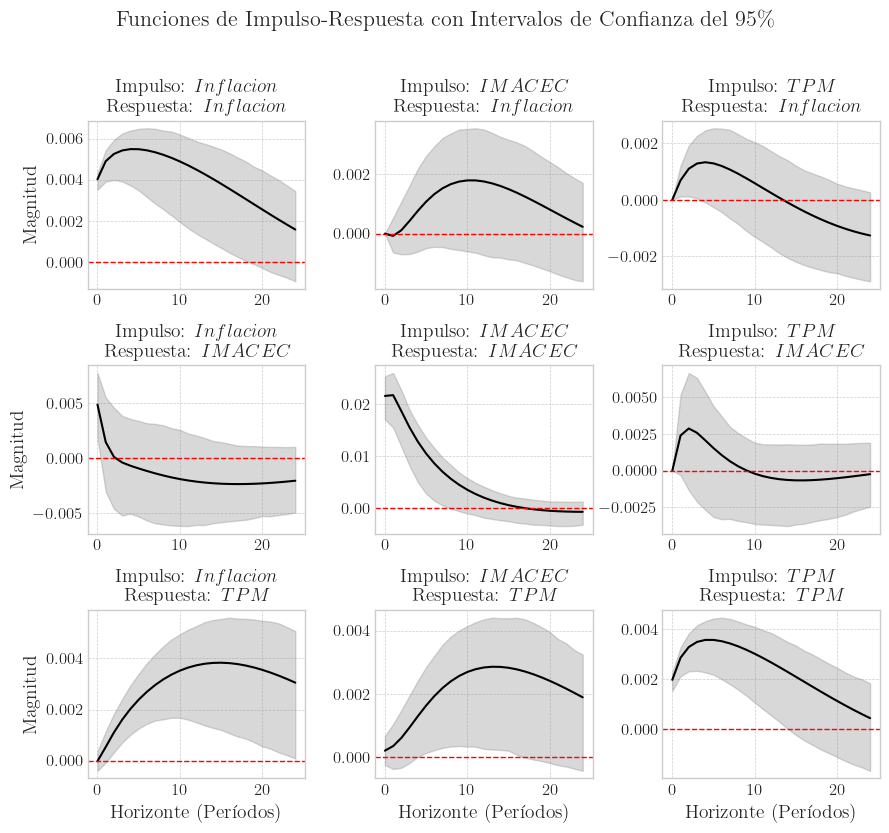

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(9,9))
fig, axes = plots.plot_irf_with_confidence_bands(
    irf_point_estimate=irf_point,
    irf_lower_band=irf_lower,
    irf_upper_band=irf_upper,
    variable_names=['Inflacion', 'IMACEC', 'TPM'],
    axes=axes, fig=fig
)
save_figure(fig, './presentation/figures/hw2/p2/irf_cholesky.pdf')

In [218]:
err = model.fit(X)
model._is_stationary()

print(model)

         Vector Autoregression (VAR) Model Summary          
VAR(p=2, n=3)
Estacionario: Sí (Max Eigenvalue: 0.9644)
------------------------------------------------------------
                 Propiedades de Largo Plazo                 
Media Incondicional:
[0.0396 0.0271 0.0439]

D.E. Incondicional:
[0.0244 0.0468 0.0253]
------------------------------------------------------------
                  Coeficientes del Modelo                   
Intercepto (c):
[ 0.0017  0.0099 -0.0004]

Matriz Phi_1:(3, 3)
Matriz Phi_2:(3, 3)
------------------------------------------------------------
          Matriz de Covarianza de Residuos (Omega)          
Omega: (3, 3)



### IRF: Cholesky 

In [219]:
cirf = model.get_irf(H=10, method='cholesky')
girf = model.get_irf(H=10, method='girf')

In [221]:
cirf.shape, girf.shape

((11, 3, 3), (11, 3, 3))

In [ ]:
pos_fit_data = model.sample(len(X))

✅ Figura guardada exitosamente en ./presentation/figures/hw2/p2/true_gen.pdf


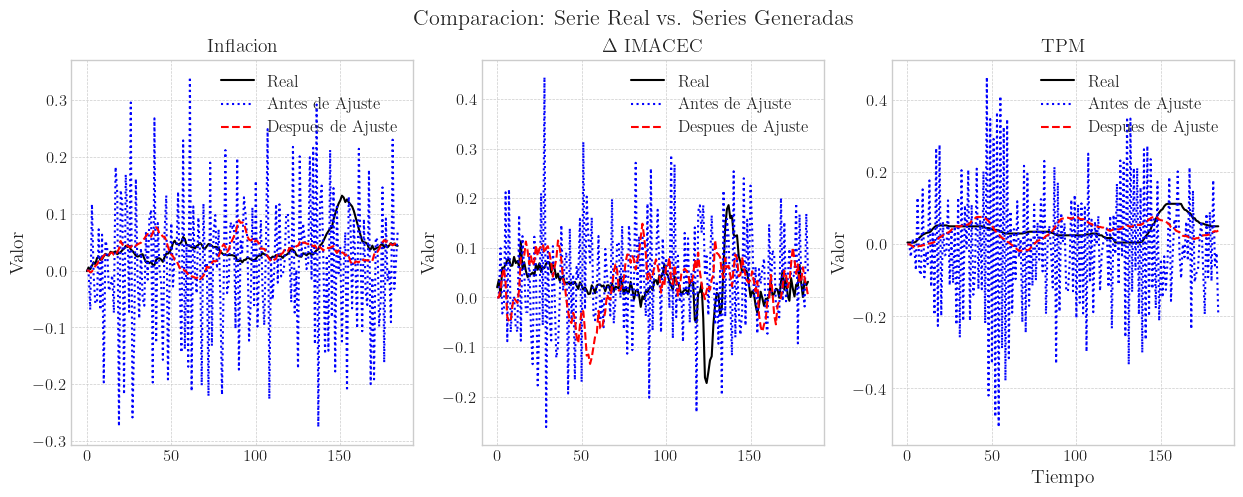

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plots.plot_real_vs_generated(X, pre_fit_data, pos_fit_data, fig=fig, axes=axes,
                             variable_names=['Inflacion', r'$\Delta$ IMACEC', 'TPM'])
save_figure(fig, './presentation/figures/hw2/p2/true_gen.pdf')